Check out the test repo and figure out which time steps have data

In [1]:
import icechunk as ic
import xarray as xr

storage = ic.s3_storage(
    bucket="nasa-eodc-public",
    prefix="icechunk/MUR-JPL-L4-GLOB-v4.1-native-v0/",
    anonymous=True,
)
repo = ic.Repository.open(storage=storage)
session = repo.readonly_session("main")
ds = xr.open_zarr(session.store, consolidated=False, zarr_format=3)

/Users/juliusbusecke/Code/titiler-multidim/.venv/lib/python3.12/site-packages/zarr/codecs/numcodecs/_codecs.py:139: ZarrUserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


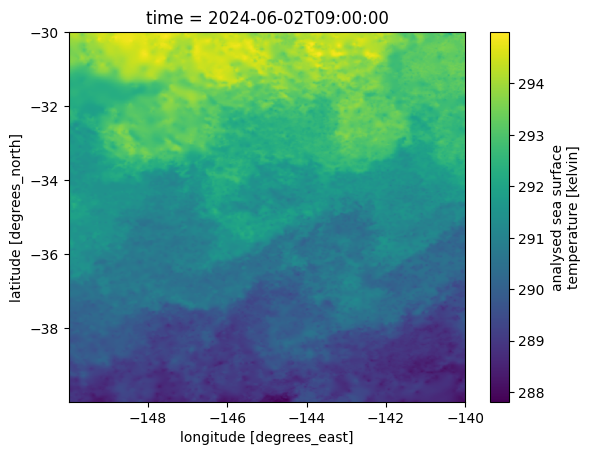

In [2]:
ds["analysed_sst"].isel(lon=slice(3000, 4000), lat=slice(5000, 6000)).plot()

## Test the tilejson endpoint 

Adopted from https://github.com/developmentseed/titiler-cmr/blob/develop/docs/examples/xarray_backend_example.ipynb

In [3]:
import json

import httpx
import xarray as xr
from folium import Map, TileLayer

titiler_endpoint = (
    "https://syonjbeb09.execute-api.us-west-2.amazonaws.com"  # dev endpoint
)


variable = "analysed_sst"
datetime_ = ds.time.values[0]
url = "s3://nasa-eodc-public/icechunk/MUR-JPL-L4-GLOB-v4.1-native-v0/"

In [4]:
r = httpx.get(
    f"{titiler_endpoint}/WebMercatorQuad/tilejson.json",
    params=(
        ("url", url),
        ("datetime", datetime_),
        ("variable", variable),
        ("rescale", "270,300"),
        ("colormap_name", "blues_r"),
        ("sel_method", "nearest"),
    ),
).json()

print(r)

{'tilejson': '2.2.0', 'version': '1.0.0', 'scheme': 'xyz', 'tiles': ['https://syonjbeb09.execute-api.us-west-2.amazonaws.com/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?url=s3%3A%2F%2Fnasa-eodc-public%2Ficechunk%2FMUR-JPL-L4-GLOB-v4.1-native-v0%2F&datetime=2024-06-02T09%3A00%3A00.000000000&variable=analysed_sst&rescale=270%2C300&colormap_name=blues_r&sel_method=nearest'], 'minzoom': 0, 'maxzoom': 6, 'bounds': [-179.99500549324037, -89.99499786365084, 180.0050000000763, 89.99499786365084], 'center': [0.00499725341796875, 0.0, 0]}


In [5]:
bounds = r["bounds"]
m = Map(location=(70, -40), zoom_start=3)

TileLayer(
    tiles=r["tiles"][0],
    opacity=1,
    attr="NASA",
).add_to(m)
m

In [6]:
geojson_dict = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "coordinates": [
                    [
                        [-20.79973248834736, 83.55979308678764],
                        [-20.79973248834736, 75.0115425216471],
                        [14.483337068956956, 75.0115425216471],
                        [14.483337068956956, 83.55979308678764],
                        [-20.79973248834736, 83.55979308678764],
                    ]
                ],
                "type": "Polygon",
            },
        }
    ],
}

r = httpx.post(
    f"{titiler_endpoint}/statistics",
    params=(
        ("url", url),
        ("datetime", datetime_),
        ("variable", variable),
    ),
    json=geojson_dict,
    timeout=60,
).json()

print(json.dumps(r, indent=2))

{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -20.79973248834736,
              83.55979308678764
            ],
            [
              -20.79973248834736,
              75.0115425216471
            ],
            [
              14.483337068956956,
              75.0115425216471
            ],
            [
              14.483337068956956,
              83.55979308678764
            ],
            [
              -20.79973248834736,
              83.55979308678764
            ]
          ]
        ]
      },
      "properties": {
        "statistics": {
          "2024-06-02T09:00:00.000000000": {
            "min": 271.34999999999997,
            "max": 279.005,
            "mean": 272.71998336321025,
            "count": 2841063.5,
            "sum": 774814790.4538239,
            "std": 2.1572893578676204,
            "median": 271.